In [1]:
import pmdarima as pm
from pmdarima.arima import auto_arima
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.api import SARIMAX
from sklearn.metrics import mean_squared_error
from pylab import rcParams

In [2]:
import pandas as pd
df = pd.read_csv("data1.csv",low_memory=False)
print(f'HomeC.csv : {df.shape}')
df.head(3)

HomeC.csv : (503852, 31)


,Unnamed: 0,time,gen..kW.,House.overall..kW.,Dishwasher..kW.,Furnace.1..kW.,Furnace.2..kW.,Home.office..kW.,Fridge..kW.,Wine.cellar..kW.,...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,59,2016-01-01 00:58:00,0.003417,0.714200,0.000033,0.021083,0.309983,0.043067,0.005167,0.123317,...,10.0,Mostly Cloudy,-1.44,1016.25,8.29,0.75,285,0.0,-4.5,0.0
1,60,2016-01-01 00:59:00,0.003417,0.497067,0.000017,0.096983,0.062867,0.043283,0.005000,0.123283,...,10.0,Mostly Cloudy,-1.44,1016.25,8.29,0.75,285,0.0,-4.5,0.0
2,61,2016-01-01 01:00:00,0.003450,0.465133,0.000017,0.064500,0.062633,0.043250,0.005017,0.123350,...,10.0,Mostly Cloudy,-1.44,1016.25,8.29,0.75,285,0.0,-4.5,0.0


In [3]:
df1 = df.drop('Unnamed: 0', axis=1)
#df1 = df1.iloc[:, :17]

In [4]:
# Sumamos furnace 1 y 2 y kitchens
df1['Furnace..kW.'] = df1['Furnace.1..kW.'] + df1['Furnace.2..kW.']
df1['Kitchen..kW.'] = df1['Kitchen.12..kW.'] + df1['Kitchen.14..kW.'] + df1['Kitchen.38..kW.']
df1.drop(['Furnace.1..kW.', 'Furnace.2..kW.', 'Kitchen.12..kW.', 'Kitchen.14..kW.', 'Kitchen.38..kW.'], axis =1, inplace=True)

In [5]:
energy_consumption_cols = ['House.overall..kW.']
weather_cols = ['temperature', 'humidity', 'visibility', 'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability']

In [6]:
df1['time'] = pd.to_datetime(df1['time'])

# Luego, establece esta columna como el índice
df1.set_index('time', inplace=True)



dfe = df1[energy_consumption_cols].resample('D').sum()
dfw = df1[weather_cols].resample('D').mean()


df_daily = pd.concat([dfe, dfw], axis = 1)

In [7]:
df_daily.head()

,House.overall..kW.,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
time,,,,,,,,,,,,
2016-01-01,1748.724983,1.511606,0.631896,9.764978,-1.904703,1014.473285,7.402229,0.565051,264.843705,0.000092,-4.741621,0.001679
2016-01-02,1840.842500,-0.060111,0.573403,9.988722,-3.942958,1014.266569,7.854611,0.266208,253.373611,0.000000,-7.529514,0.000000
2016-01-03,1571.230283,0.481972,0.646222,9.935014,-3.146806,1009.118792,7.565542,0.141875,236.936111,0.000000,-5.550653,0.000000
2016-01-04,1729.139800,-8.062542,0.560111,9.870042,-15.334319,1020.457903,12.302556,0.130528,311.866667,0.000000,-15.318972,0.000000
2016-01-05,1353.719217,-10.867639,0.573222,9.986958,-14.447736,1035.298125,4.856056,0.002167,293.073611,0.000000,-18.114264,0.000000


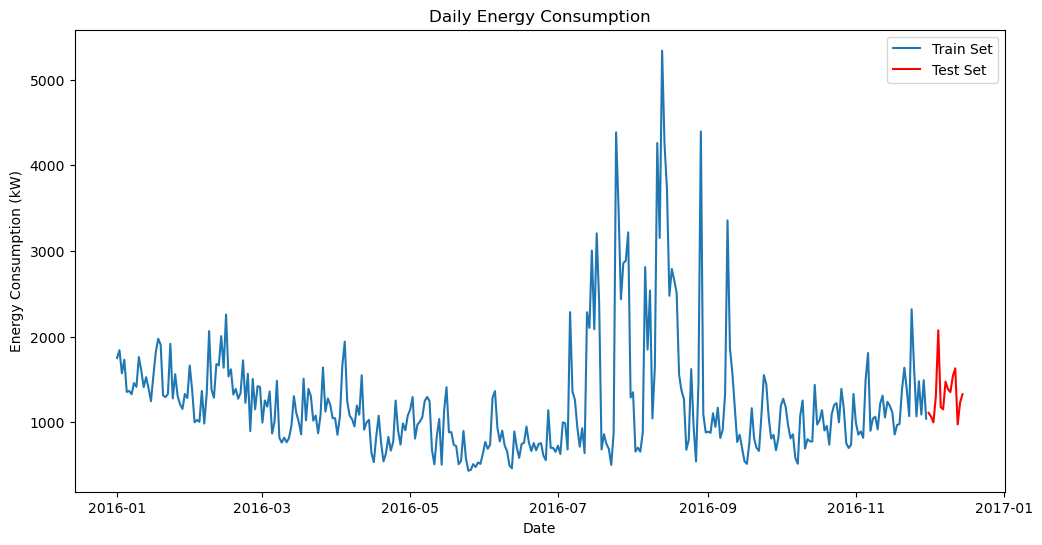

                                     SARIMAX Results                                     
Dep. Variable:                House.overall..kW.   No. Observations:                  335
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -2442.574
Date:                           Tue, 21 May 2024   AIC                           4917.147
Time:                                   14:08:09   BIC                           4977.340
Sample:                               01-01-2016   HQIC                          4941.189
                                    - 11-30-2016                                         
Covariance Type:                             opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
temperature            -6.9925    158.657     -0.044      0.965    -317.954     303.969
humidity        

C:\Users\pablo\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


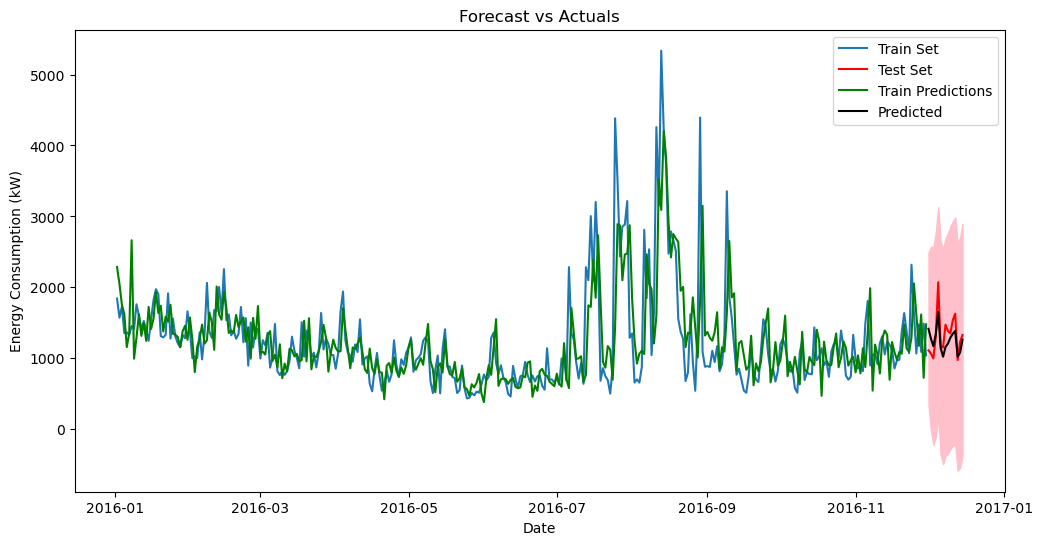

The RMSE of the model is 203.74113505314253 kW
The MAPE of the model is 12.64%


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error
import numpy as np

# Split data into training and testing
train_size = len(df_daily) - 15
train_set, test_set = df_daily.iloc[:train_size], df_daily.iloc[train_size:]

# Visualization of data
plt.figure(figsize=(12, 6))
plt.plot(train_set.index.to_numpy(), train_set['House.overall..kW.'].to_numpy(), label='Train Set')
plt.plot(test_set.index.to_numpy(), test_set['House.overall..kW.'].to_numpy(), label='Test Set', color='r')
plt.title('Daily Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kW)')
plt.legend()
plt.show()

# Create SARIMAX model
sarimax_model = SARIMAX(train_set['House.overall..kW.'],
                        exog=train_set[weather_cols],
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 7),
                        enforce_stationarity=False,
                        enforce_invertibility=False)

# Fit the model
sarimax_result = sarimax_model.fit(disp=False)
print(sarimax_result.summary())

# Predict
train_predictions = sarimax_result.get_prediction(start=train_set.index[0], end=train_set.index[-1], exog=train_set[weather_cols])
train_predicted_means = train_predictions.predicted_mean
train_conf_int = train_predictions.conf_int()

predictions = sarimax_result.get_forecast(steps=15, exog=test_set[weather_cols])
predicted_means = predictions.predicted_mean
conf_int = predictions.conf_int()

# Visualization of predictions
plt.figure(figsize=(12, 6))
plt.plot(train_set.index[1:].to_numpy(), train_set['House.overall..kW.'][1:].to_numpy(), label='Train Set')
plt.plot(test_set.index.to_numpy(), test_set['House.overall..kW.'].to_numpy(), label='Test Set', color='r')
plt.plot(train_set.index[1:].to_numpy(), train_predicted_means[1:].to_numpy(), label='Train Predictions', color='g')
plt.plot(test_set.index.to_numpy(), predicted_means.to_numpy(), label='Predicted', color='black')
plt.fill_between(test_set.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink')
plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kW)')
plt.legend()
plt.show()


#plt.figure(figsize=(12, 6))
#plt.plot(train_set.index, train_set['Fridge..kW.'], label='Train Set')
#plt.plot(test_set.index, test_set['Fridge..kW.'], label='Test Set', color='r')
#plt.plot(train_set.index, train_predicted_means, label='Train Predictions', color='g', linestyle='--')
#plt.plot(test_set.index, predicted_means, label='Test Predictions', color='b', linestyle='--')
#plt.fill_between(train_set.index, train_conf_int.iloc[:, 0], train_conf_int.iloc[:, 1], color='pink', alpha=0.3)
#plt.fill_between(test_set.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='yellow', alpha=0.3)
#plt.title('Forecast vs Actuals')
#plt.xlabel('Date')
#plt.ylabel('Energy Consumption (kW)')
#plt.legend()
#plt.show()


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_set['House.overall..kW.'], predicted_means))
print(f'The RMSE of the model is {rmse} kW')
mape = mean_absolute_percentage_error(test_set['House.overall..kW.'], predicted_means) * 100  # Convert to percentage
print(f'The MAPE of the model is {mape:.2f}%')


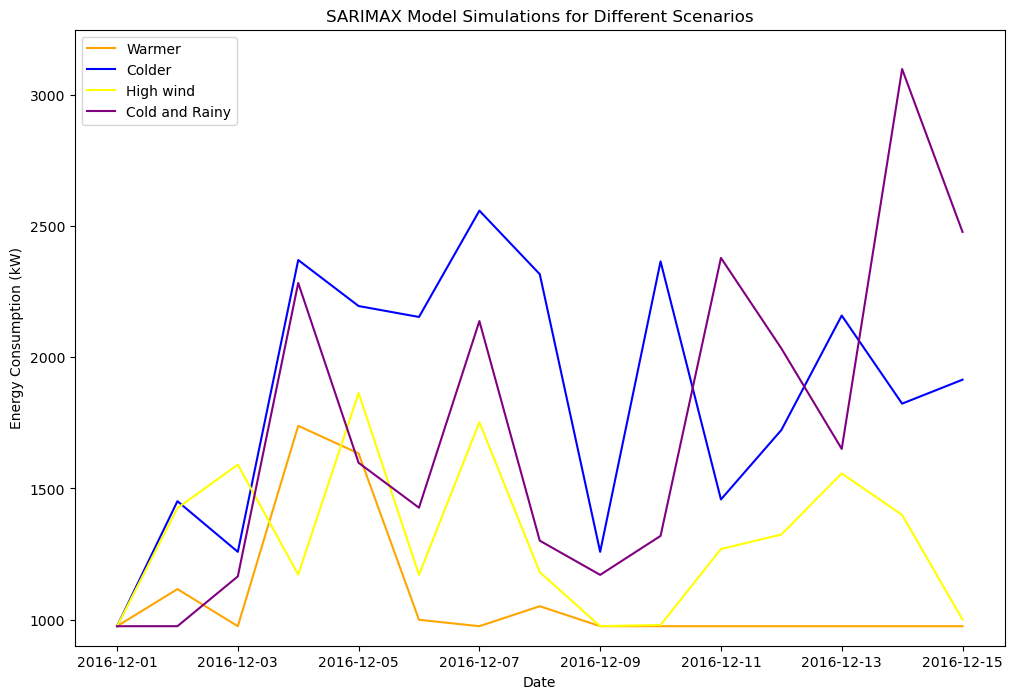

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(3)
def generate_simulations(n_simulations, adjust_fn):
    simulated_paths = []
    min_value = test_set[energy_consumption_cols[0]].min()
    last_15_rows = train_set.tail(15)
    mean_consumption = last_15_rows['House.overall..kW.'].mean()
    std_consumption = last_15_rows['House.overall..kW.'].std()

    while len(simulated_paths) < n_simulations:
        initial_state = np.array([mean_consumption, std_consumption, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
        adjusted_test_set = last_15_rows.copy()
        adjusted_test_set = adjust_fn(adjusted_test_set)
        sim = sarimax_result.simulate(nsimulations=15, exog=adjusted_test_set[weather_cols], initial_state=initial_state)
        sim_df = pd.DataFrame(sim, columns=[energy_consumption_cols[0]])

        if not (sim_df < min_value).all().any():
            sim_df[energy_consumption_cols[0]] = np.clip(sim_df[energy_consumption_cols[0]], min_value, None)
            simulated_paths.append(sim_df)

    simulated_paths_df = pd.concat(simulated_paths, axis=1)
    simulated_paths_df.columns = [f'Simulation_{i+1}' for i in range(len(simulated_paths_df.columns))]
    return simulated_paths_df

def adjust_warmer(df):
    temperature_increase = np.random.uniform(2, 5, size=len(df))
    df['temperature'] += temperature_increase
    df['apparentTemperature'] += temperature_increase
    return df

def adjust_colder(df):
    temperature_decrease = np.random.uniform(-5, -10, size=len(df))
    df['temperature'] += temperature_decrease
    df['apparentTemperature'] += temperature_decrease
    return df

def adjust_wind_increase(df):
    wind_speed_increase = 5  
    wind_speed_variation = 2 
    df['windSpeed'] = df['windSpeed'] + wind_speed_increase + np.random.normal(0, wind_speed_variation, size=len(df))
    return df

def adjust_rainy_cold(df):
    temperature_decrease = np.random.uniform(-5, -10, size=len(df))
    rain_probability_increase = np.random.uniform(0.4, 0.6, size=len(df))
    visibility_shift = np.random.uniform(-5, -10, size=len(df))
    
    df['temperature'] += temperature_decrease
    df['apparentTemperature'] += temperature_decrease
    df['precipProbability'] = np.clip(df['precipProbability'] + rain_probability_increase, 0, 1)
    visibility_random = np.random.normal(0, 2, size=len(df))
    df['visibility'] = np.where(np.arange(len(df)) % 3 == 0, df['visibility'] + visibility_shift + visibility_random, df['visibility'])
    
    return df


simulated_paths_df_warmer = generate_simulations(1, adjust_warmer)
simulated_paths_df_colder = generate_simulations(1, adjust_colder)
simulated_paths_df_wind = generate_simulations(1, adjust_wind_increase)
simulated_paths_df_rainy_cold = generate_simulations(1, adjust_rainy_cold)

plt.figure(figsize=(12, 8))

# Graficar escenario Mild Winter
for column in simulated_paths_df_warmer.columns:
    plt.plot(test_set.index, simulated_paths_df_warmer[column],color='orange')
# Graficar escenario Colder winter
for column in simulated_paths_df_colder.columns:
    plt.plot(test_set.index, simulated_paths_df_colder[column], color='blue')
# Graficar High Wind
for column in simulated_paths_df_wind.columns:
    plt.plot(test_set.index, simulated_paths_df_wind[column],color='yellow')
# Graficar escenario de frío, lluvia y poca visibilidad
for column in simulated_paths_df_rainy_cold.columns:
    plt.plot(test_set.index, simulated_paths_df_rainy_cold[column], color='purple')

plt.xlabel('Date')
plt.ylabel('Energy Consumption (kW)')
plt.title('SARIMAX Model Simulations for Different Scenarios')
plt.legend(['Warmer', 'Colder', 'High wind', 'Cold and Rainy'])
plt.ylim(900,3250)
plt.show()


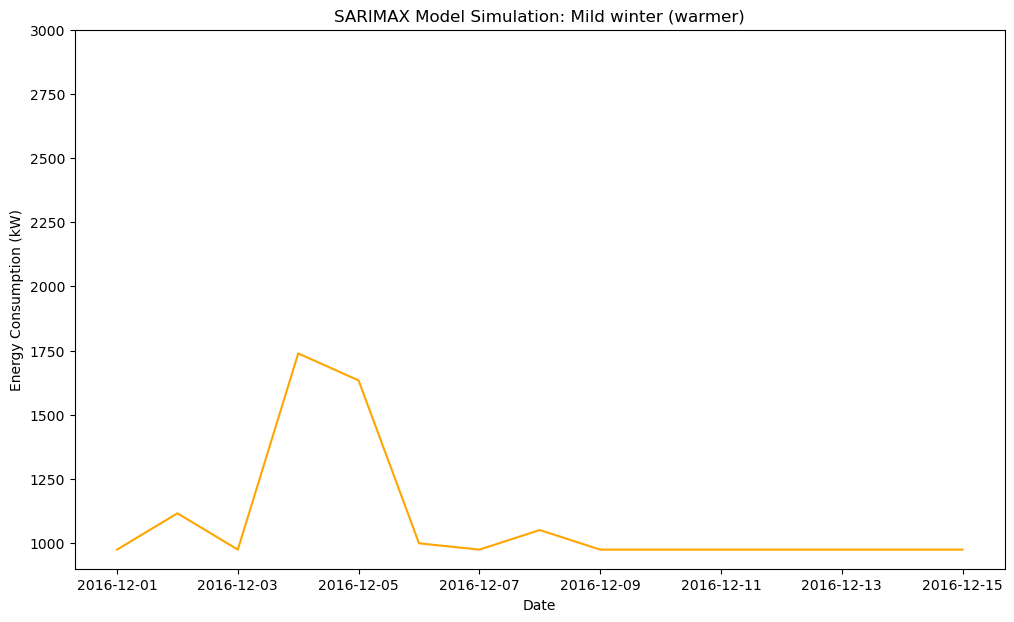

In [11]:
plt.figure(figsize=(12, 7))
for column in simulated_paths_df_warmer.columns:
    plt.plot(test_set.index, simulated_paths_df_warmer[column],color='orange')
    
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kW)')
plt.title('SARIMAX Model Simulation: Mild winter (warmer)')
plt.ylim(900,3000)
plt.show()

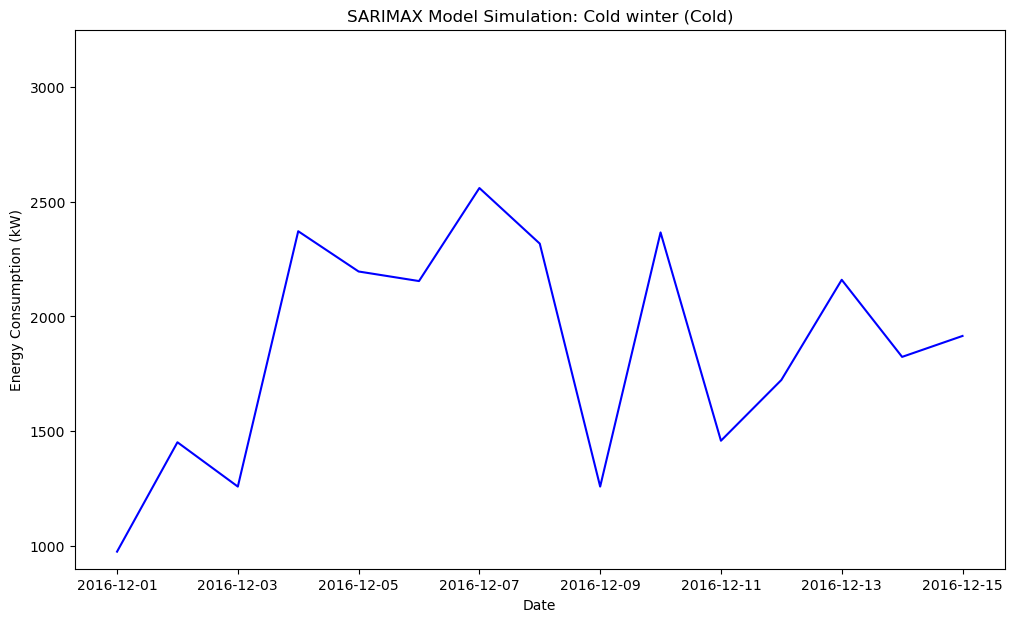

In [12]:
plt.figure(figsize=(12, 7))
for column in simulated_paths_df_colder.columns:
    plt.plot(test_set.index, simulated_paths_df_colder[column], color='blue')
    
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kW)')
plt.title('SARIMAX Model Simulation: Cold winter (Cold)')
plt.ylim(900,3250)
plt.show()

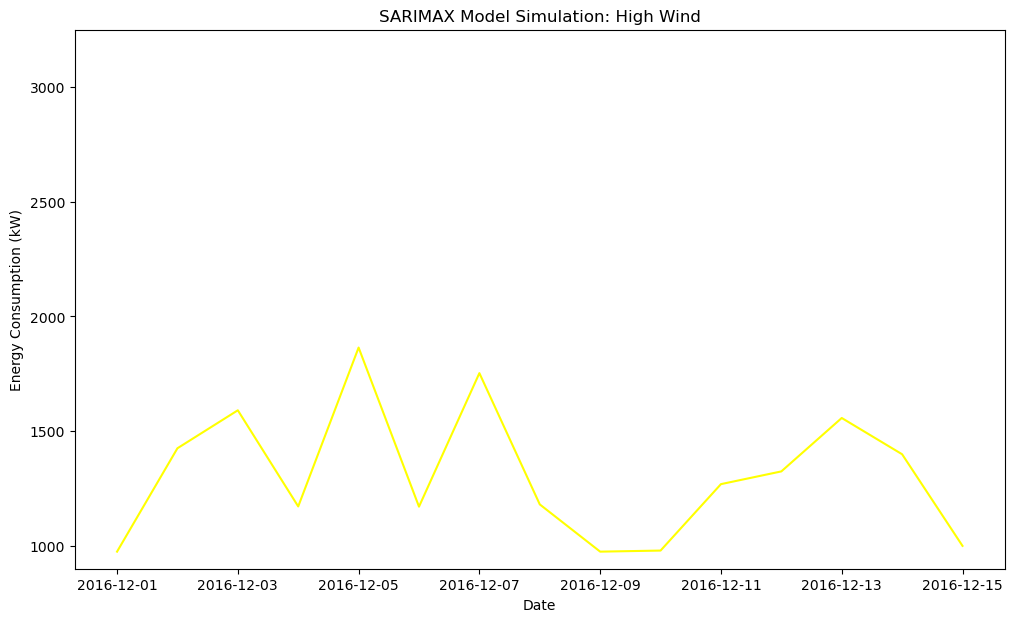

In [13]:
plt.figure(figsize=(12, 7))
for column in simulated_paths_df_wind.columns:
    plt.plot(test_set.index, simulated_paths_df_wind[column],color='yellow')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kW)')
plt.title('SARIMAX Model Simulation: High Wind')
plt.ylim(900,3250)
plt.show()

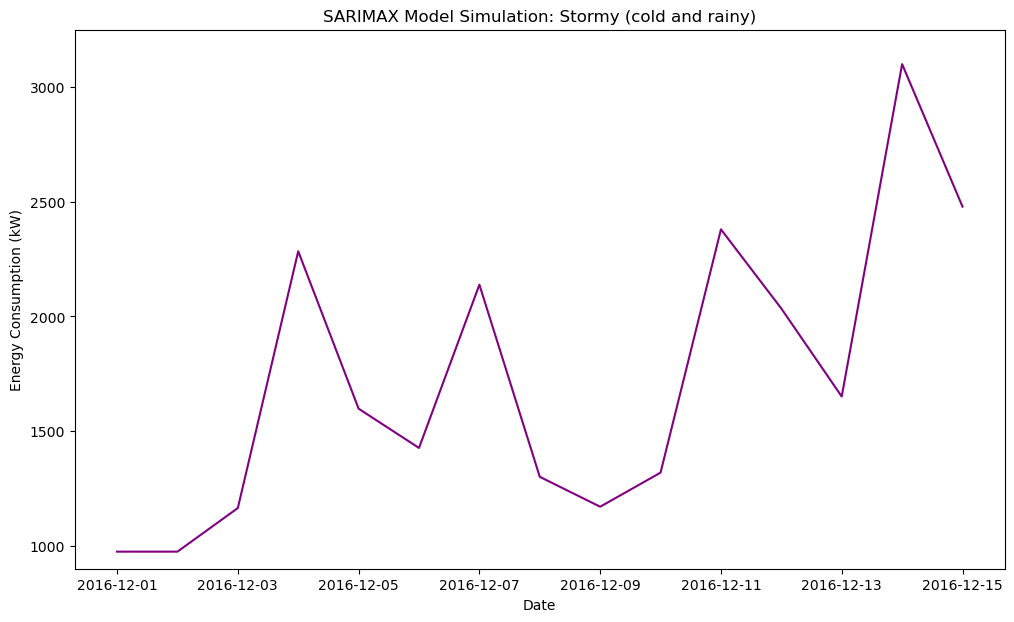

In [14]:
plt.figure(figsize=(12, 7))
for column in simulated_paths_df_rainy_cold.columns:
    plt.plot(test_set.index, simulated_paths_df_rainy_cold[column], color='purple')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kW)')
plt.title('SARIMAX Model Simulation: Stormy (cold and rainy)')
plt.ylim(900,3250)
plt.show()